In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!git log -n 1

commit 201bb4125d72a0cc89a90c2f79b240ece2e76f2b (HEAD, origin/rerun_DISK_57, rerun_DISK_57)
Author: dalessioluca <ldalessi@broadinstitute.org>
Date:   Mon Nov 23 09:39:17 2020 -0500

    plot more fmaps


In [14]:
from MODULES.vae_model import *
from MODULES.utilities_ml import SpecialDataSet
from MODULES.utilities import load_json_as_dict
from typing import Tuple
from torchvision import utils

# Check versions
import torch
import numpy
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

# make sure to fix the randomness at the very beginning
torch.manual_seed(0)
numpy.random.seed(0)

def show_batch(images: torch.Tensor,
               n_col: int = 4,
               n_padding: int = 10,
               title: Optional[str] = None,
               pad_value: int = 1,
               normalize_range: Optional[tuple] = None,
               figsize: Optional[Tuple[float, float]] = None):

    """Visualize a torch tensor of shape: (batch x ch x width x height) """
    assert len(images.shape) == 4  # batch, ch, width, height
    if images.device != "cpu":
        images = images.cpu()

    # Always normalize the image in (0,1) either using min_max of tensor or normalize_range
    grid = utils.make_grid(images, n_col, n_padding, normalize=True, range=normalize_range,
                           scale_each=False, pad_value=pad_value)
        
    fig = plt.figure(figsize=figsize)
    plt.imshow(grid.detach().permute(1, 2, 0).squeeze(-1).numpy())
    plt.axis("off")
    if isinstance(title, str):
        plt.title(title)
    fig.tight_layout()
    
    plt.close(fig)
    return fig

python_version() --->  3.8.2
torch.__version__ -->  1.6.0


## Get the test_datasets

In [6]:
img_test, seg_mask_test, count_test = load_obj("./BLOBS-run-DIS-86/blobs_NO_shading_test_DIS-86.pt")
test_loader_blobs = SpecialDataSet(img=img_test,
                                   roi_mask=None,
                                   seg_mask=seg_mask_test,
                                   labels=count_test,
                                   batch_size=50,
                                   drop_last=False,
                                   shuffle=False)

## Get the trained model

In [7]:
params_blobs = load_json_as_dict("./BLOBS-run-DIS-86/ML_parameters_DIS-86.json")
vae_blobs = CompositionalVae(params_blobs)
ckpt_blobs = file2ckpt(path="./BLOBS-run-DIS-86/ckpt_250_run_DIS-86.pt", device='cpu')
load_from_ckpt(ckpt=ckpt_blobs,
               model=vae_blobs,
               optimizer=None,
               overwrite_member_var=True)

## Find interesting example images 

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])


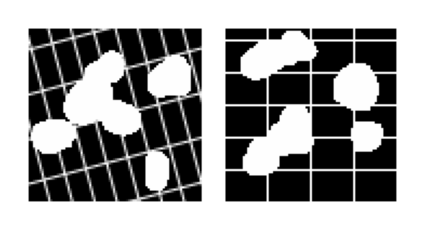

In [33]:
index_tmp = torch.arange(test_loader_blobs.img.shape[0])[:128]
tmp_imgs, tmp_seg, tmp_count = test_loader_blobs.load(index=index_tmp)[:3]
mask = (tmp_count == 6) + (tmp_count == 5)
index = index_tmp[mask][:16]

print(index)
index = torch.tensor([1, 8, 12,14], dtype=torch.long)
index = torch.tensor([1, 12], dtype=torch.long)


ref_imgs, ref_seg, ref_count = test_loader_blobs.load(index=index)[:3]
show_batch(ref_imgs)

## run inference

In [34]:
with torch.no_grad():
    output = vae_blobs.forward(ref_imgs,
                               overlap_threshold=0.5,
                               noisy_sampling=True,
                               draw_image=True,
                               draw_boxes=True,
                               draw_bg=True,
                               verbose=False)
    

## Plot interesting stuff

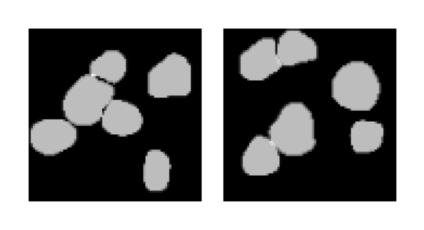

In [35]:
show_batch(output.inference.big_mask_times_c.sum(dim=-5))

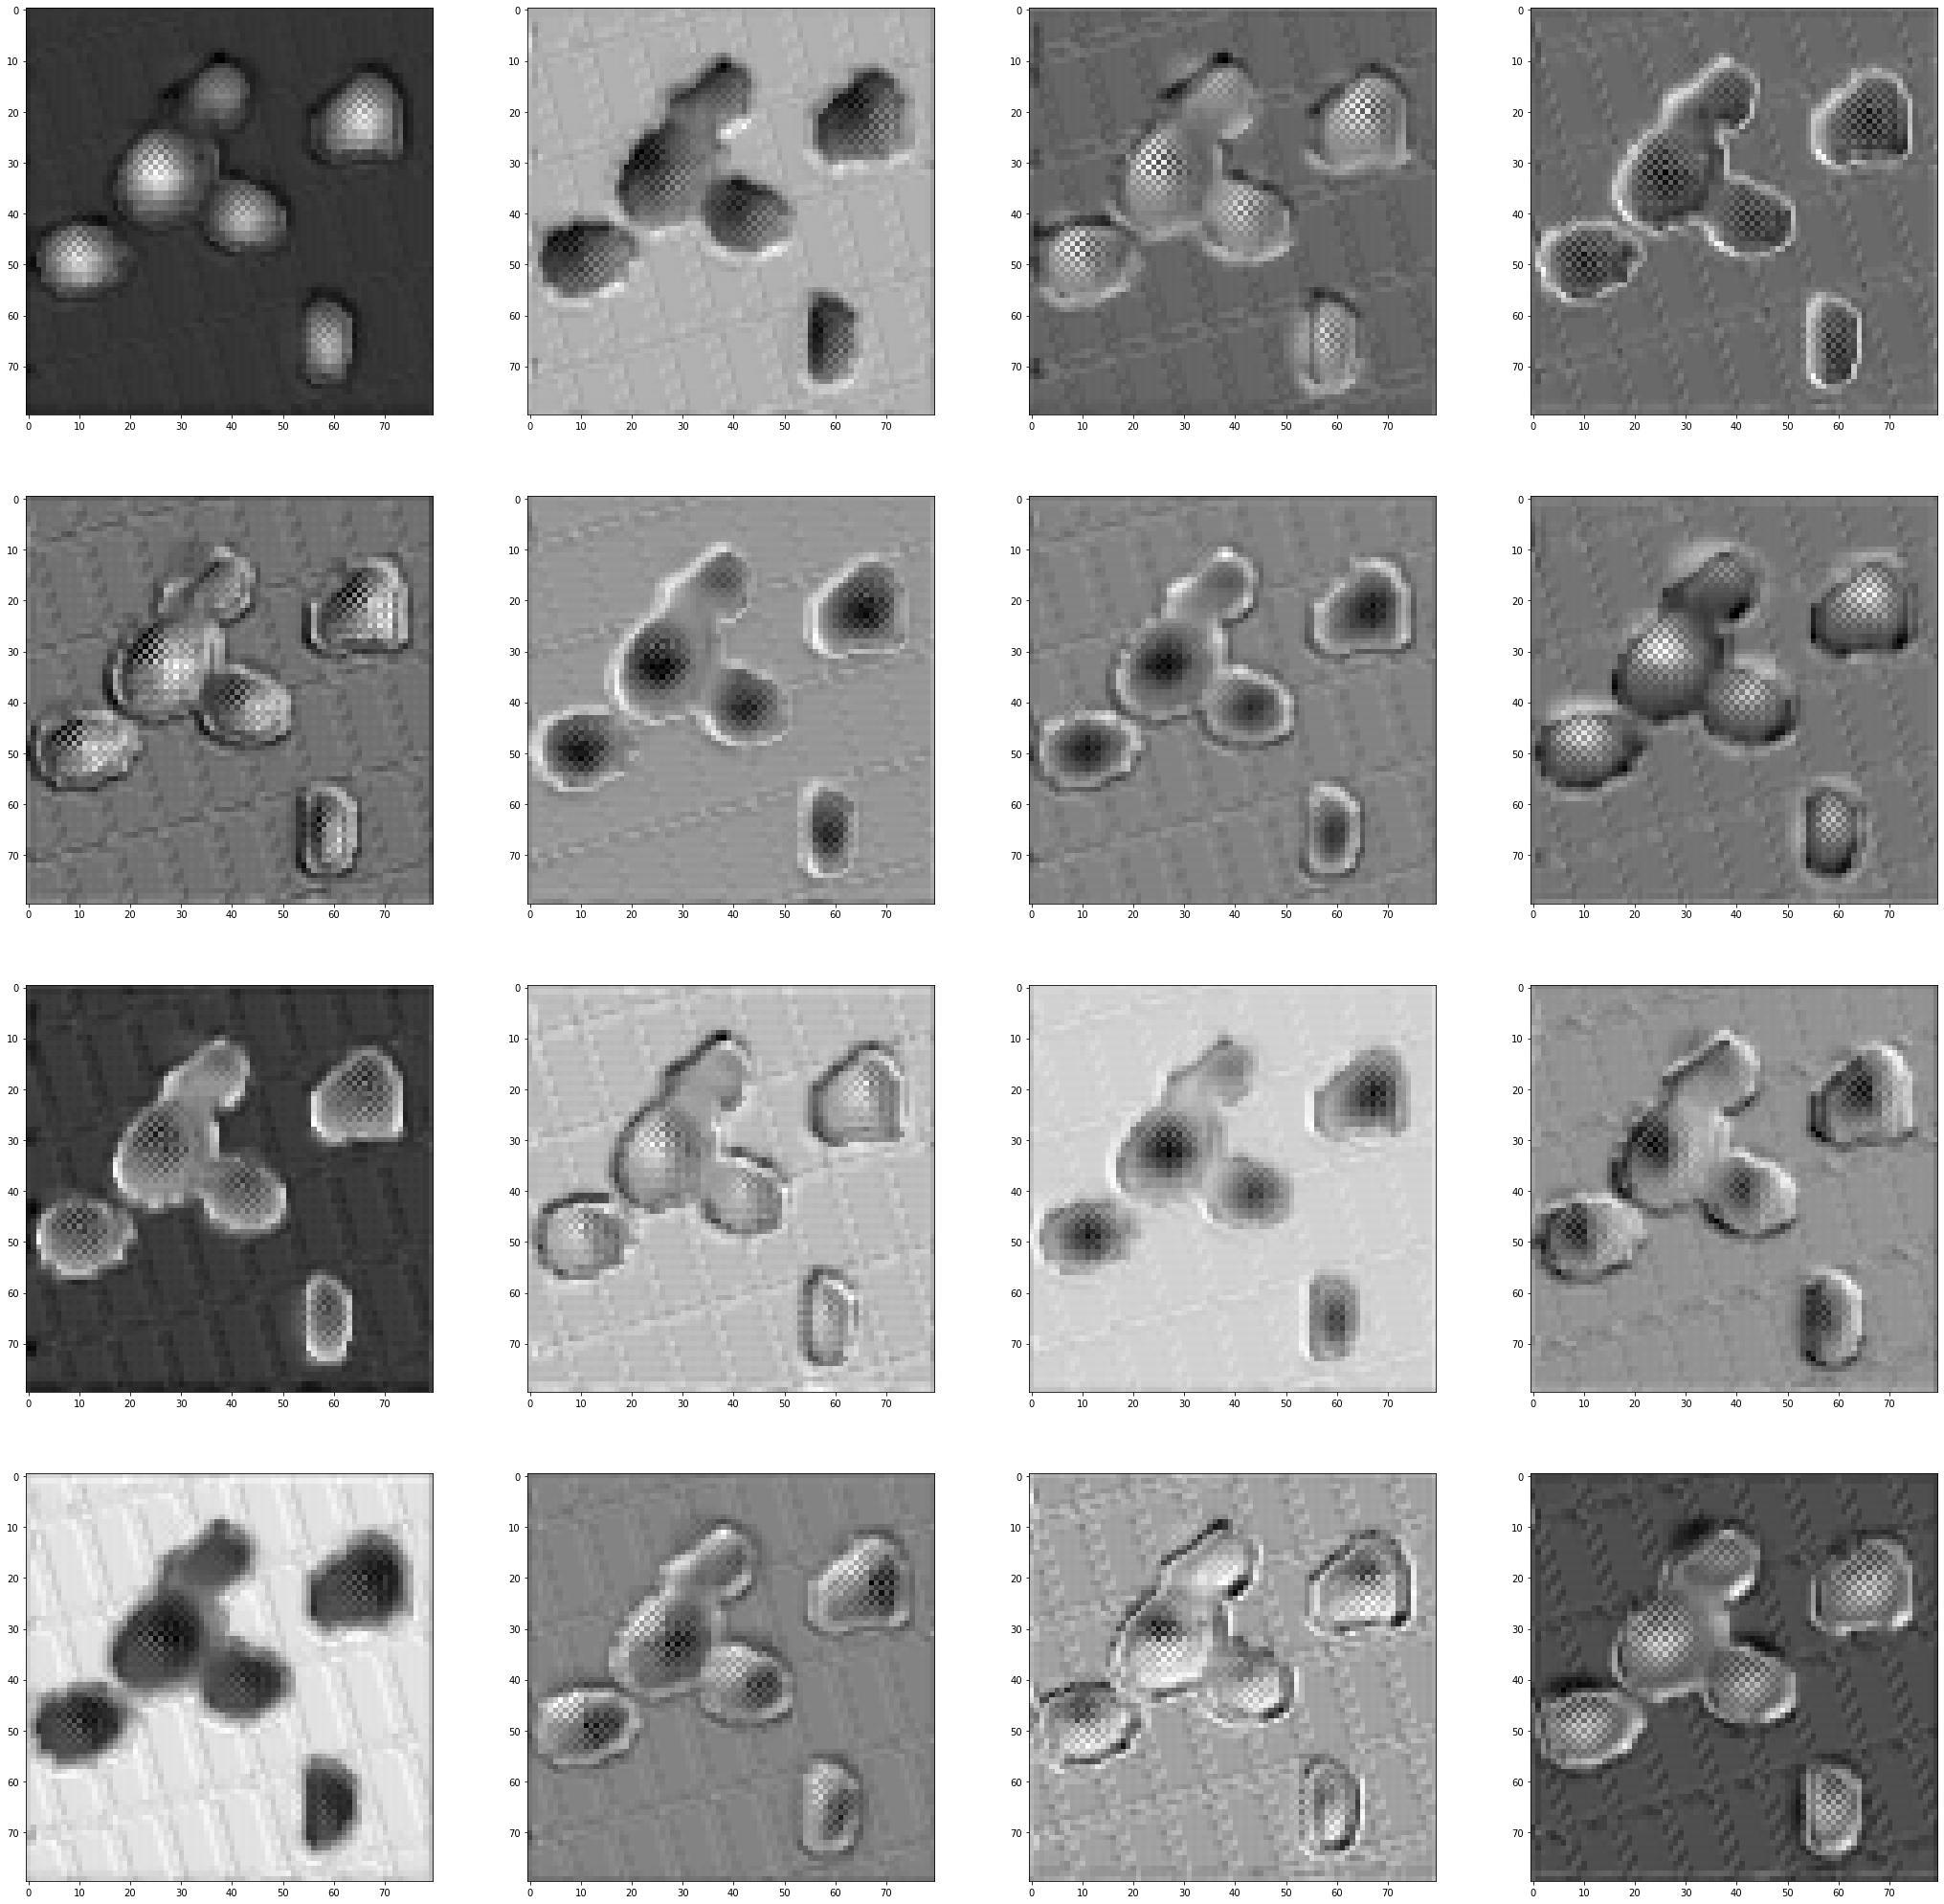

In [36]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(36,36))
n = -1
for r in range(4):
    for c in range(4):
        n += 1
        ax[r,c].imshow(output.inference.feature_map[0,n],  cmap='gray')

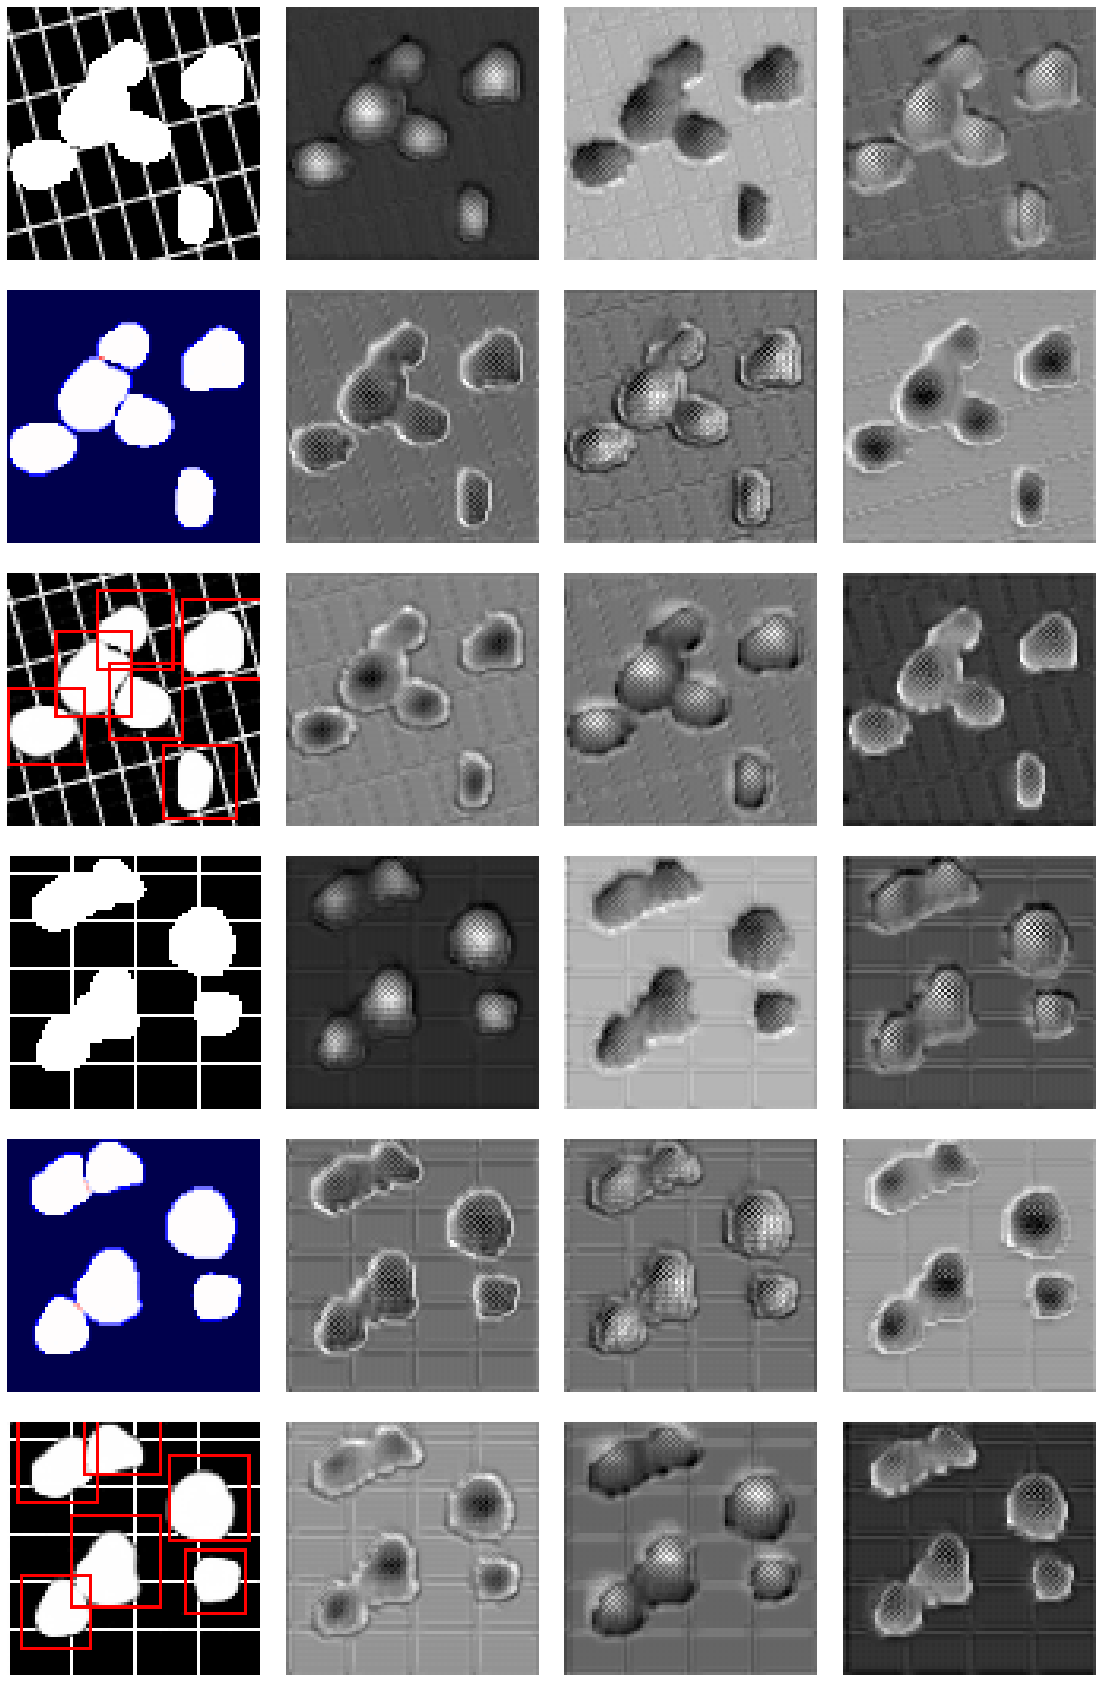

In [39]:
n_example = ref_imgs.shape[0]
ch_fmap = output.inference.feature_map.shape[-3]
overlap = output.inference.big_mask_times_c.sum(dim=-5)

#ch_to_show = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
ch_to_show = [0,4,6,7,8,10,13,14,15]
ncols = 1+len(ch_to_show)//3
fig, ax = plt.subplots(ncols=ncols, nrows=n_example*3, figsize=(4*ncols,12*n_example))

for r in range(n_example):
    ax[3*r,0].imshow(ref_imgs[r,0], cmap='gray')
    ax[3*r+1,0].imshow(overlap[r,0], vmin=0, vmax=2, cmap='seismic')
    ax[3*r+2,0].imshow(output.imgs[r].permute(1,2,0))
    ax[3*r,0].axis('off')
    ax[3*r+1,0].axis('off')
    ax[3*r+2,0].axis('off')
    for c, ch in enumerate(ch_to_show):
        col = c % (ncols-1)  
        extra_row = c // (ncols-1)
        ax[3*r+extra_row, col+1].imshow(output.inference.feature_map[r,c], cmap='gray')
        ax[3*r+extra_row, col+1].axis('off')

fig.tight_layout(pad=3.0)
fig.savefig("./fmap.pdf")
fig.savefig("./fmap.png")

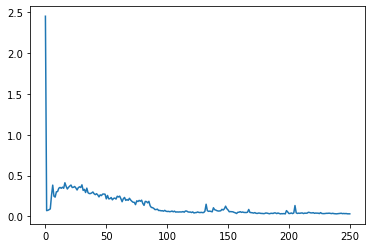

In [46]:
reg_overlap = ckpt_blobs["history_dict"]["train_reg_overlap"]

plt.plot(reg_overlap)

numpy.save("./reg_overlap", reg_overlap, allow_pickle=False)